In [2]:
#!/usr/bin/env python3
"""
癫痫数据平衡处理系统（被试级别平衡）
功能：
1. 自动识别文件命名格式（如chb01_chb01_01.npz）
2. 按被试分组处理，避免全局加载
3. 严格1:1平衡前期(preictal)和间期(interictal)
4. 支持随机种子设置确保可复现性
"""

import os
import glob
import numpy as np
from collections import defaultdict
from sklearn.utils import resample
import warnings
warnings.filterwarnings("ignore")

class SubjectBalanceProcessor:
    def __init__(self, data_dir: str, output_dir: str, random_seed: int = 42):
        self.data_dir = data_dir
        self.output_dir = output_dir
        self.random_seed = random_seed
        os.makedirs(output_dir, exist_ok=True)
        
        # 初始化随机种子
        np.random.seed(self.random_seed)
        
    def scan_subjects(self) -> dict:
        """扫描所有被试数据"""
        subject_files = defaultdict(lambda: {'mixed': [], 'interictal': [], 'preictal_count': 0})
        
        for npz_file in glob.glob(os.path.join(self.data_dir, "*.npz")):
            # 解析被试ID（兼容chb01_chb01_01.npz和chb01_01.npz格式）
            basename = os.path.basename(npz_file)
            if basename.startswith('chb') and '_chb' in basename:
                subject = basename.split('_')[0]  # chb01
            else:
                subject = basename.split('_')[0]  # 兼容其他格式
            
            # 轻量级检测文件类型
            with np.load(npz_file) as data:
                labels = data['labels']
                n_preictal = np.sum(labels == 1)
                
            if n_preictal > 0:
                subject_files[subject]['mixed'].append(npz_file)
                subject_files[subject]['preictal_count'] += n_preictal
            else:
                subject_files[subject]['interictal'].append(npz_file)
                
        print(f"发现 {len(subject_files)} 个被试的数据")
        return subject_files
    
    def balance_subject(self, subject: str, files: dict):
        """处理单个被试"""
        # 确保每次处理都使用相同的随机状态
        rng = np.random.RandomState(self.random_seed)
        
        total_preictal = files['preictal_count']
        if total_preictal == 0:
            print(f"跳过 {subject} (无前期数据)")
            return
        
        print(f"\n处理 {subject}: 需平衡 {total_preictal} 个前期窗口")
        
        # 收集所有可用间期文件
        all_interictal_files = files['mixed'] + files['interictal']
        if not all_interictal_files:
            print(f"警告: {subject} 无可用间期数据")
            return
            
        # 从各文件抽取的窗口数（按文件大小加权）
        file_weights = [os.path.getsize(f) for f in all_interictal_files]
        sample_counts = self.weighted_split(total_preictal, file_weights)
        
        # 实际抽取间期数据
        interictal_windows = []
        for file, count in zip(all_interictal_files, sample_counts):
            if count == 0:
                continue
            with np.load(file) as data:
                idx = np.where(data['labels'] == 0)[0]
                selected = rng.choice(idx, min(count, len(idx)), replace=False)
                interictal_windows.append(data['windows'][selected])
        
        # 收集所有前期数据
        preictal_windows = []
        for file in files['mixed']:
            with np.load(file) as data:
                preictal_windows.append(data['windows'][data['labels'] == 1])
        
        # 合并结果
        balanced_data = np.concatenate(interictal_windows + preictal_windows)
        balanced_labels = np.concatenate([
            np.zeros(sum(len(w) for w in interictal_windows)),
            np.ones(sum(len(w) for w in preictal_windows))
        ])
        
        # 打乱顺序（使用相同的随机状态）
        shuffle_idx = rng.permutation(len(balanced_labels))
        balanced_data = balanced_data[shuffle_idx]
        balanced_labels = balanced_labels[shuffle_idx]
        
        # 保存结果
        output_path = os.path.join(self.output_dir, f"balanced_{subject}.npz")
        np.savez_compressed(
            output_path,
            windows=balanced_data,
            labels=balanced_labels,
            preictal_sources=[os.path.basename(f) for f in files['mixed']],
            interictal_sources=[os.path.basename(f) for f in all_interictal_files],
            random_seed_used=self.random_seed  # 保存使用的随机种子
        )
        print(f"已保存 {output_path} (窗口数: {len(balanced_data)})")
    
    @staticmethod
    def weighted_split(total: int, weights: list) -> list:
        """按权重分配抽样数量"""
        weights = np.array(weights) / np.sum(weights)
        counts = np.floor(weights * total).astype(int)
        remainder = total - np.sum(counts)
        if remainder > 0:
            counts[np.argsort(weights)[-remainder:]] += 1
        return counts.tolist()

def main():
    # 配置路径和参数
    DATA_DIR = "/root/processed_results"  # 包含 chb01_chb01_01.npz 等文件
    OUTPUT_DIR = "/root/balanced_data"
    RANDOM_SEED = 42  # 可修改为任意整数
    
    # 处理流程
    processor = SubjectBalanceProcessor(DATA_DIR, OUTPUT_DIR, RANDOM_SEED)
    subject_files = processor.scan_subjects()
    
    for subject, files in subject_files.items():
        processor.balance_subject(subject, files)

if __name__ == "__main__":
    main()

发现 13 个被试的数据

处理 chb19: 需平衡 85 个前期窗口
已保存 /root/balanced_data/balanced_chb19.npz (窗口数: 170)

处理 chb23: 需平衡 207 个前期窗口
已保存 /root/balanced_data/balanced_chb23.npz (窗口数: 414)

处理 chb01: 需平衡 43 个前期窗口
已保存 /root/balanced_data/balanced_chb01.npz (窗口数: 86)

处理 chb02: 需平衡 93 个前期窗口
已保存 /root/balanced_data/balanced_chb02.npz (窗口数: 186)

处理 chb03: 需平衡 47 个前期窗口
已保存 /root/balanced_data/balanced_chb03.npz (窗口数: 94)

处理 chb21: 需平衡 61 个前期窗口
已保存 /root/balanced_data/balanced_chb21.npz (窗口数: 122)

处理 chb20: 需平衡 45 个前期窗口
已保存 /root/balanced_data/balanced_chb20.npz (窗口数: 90)

处理 chb18: 需平衡 84 个前期窗口
已保存 /root/balanced_data/balanced_chb18.npz (窗口数: 168)

处理 chb14: 需平衡 130 个前期窗口
已保存 /root/balanced_data/balanced_chb14.npz (窗口数: 260)

处理 chb13: 需平衡 130 个前期窗口
已保存 /root/balanced_data/balanced_chb13.npz (窗口数: 259)

处理 chb10: 需平衡 301 个前期窗口
已保存 /root/balanced_data/balanced_chb10.npz (窗口数: 602)

处理 chb09: 需平衡 219 个前期窗口
已保存 /root/balanced_data/balanced_chb09.npz (窗口数: 438)

处理 chb05: 需平衡 59 个前期窗口
已保存 /root/balanced_data/b

#X是数据 y是标签（0,1）


正在检查文件: /root/balanced_data/balanced_chb01.npz
被试ID: chb01.npz
随机种子: 42

[数据维度]
窗口数: 86
通道数: 6
每窗口样本数: 7680

[标签分布]
间期: 43个 (50.0%)
前期: 43个 (50.0%)

[数据来源]
前期来源: ['chb01_chb01_03.npz' 'chb01_chb01_26.npz']
间期来源: ['chb01_chb01_03.npz' 'chb01_chb01_26.npz' 'chb01_chb01_01.npz'
 'chb01_chb01_02.npz' 'chb01_chb01_04.npz' 'chb01_chb01_05.npz'
 'chb01_chb01_06.npz' 'chb01_chb01_07.npz' 'chb01_chb01_08.npz'
 'chb01_chb01_09.npz' 'chb01_chb01_10.npz' 'chb01_chb01_11.npz'
 'chb01_chb01_12.npz' 'chb01_chb01_13.npz' 'chb01_chb01_14.npz'
 'chb01_chb01_15.npz' 'chb01_chb01_16.npz' 'chb01_chb01_17.npz'
 'chb01_chb01_18.npz' 'chb01_chb01_19.npz' 'chb01_chb01_20.npz'
 'chb01_chb01_21.npz' 'chb01_chb01_22.npz' 'chb01_chb01_23.npz'
 'chb01_chb01_24.npz' 'chb01_chb01_25.npz' 'chb01_chb01_27.npz'
 'chb01_chb01_29.npz' 'chb01_chb01_30.npz' 'chb01_chb01_31.npz'
 'chb01_chb01_32.npz' 'chb01_chb01_33.npz' 'chb01_chb01_34.npz'
 'chb01_chb01_36.npz' 'chb01_chb01_37.npz' 'chb01_chb01_38.npz'
 'chb01_chb01_39.np

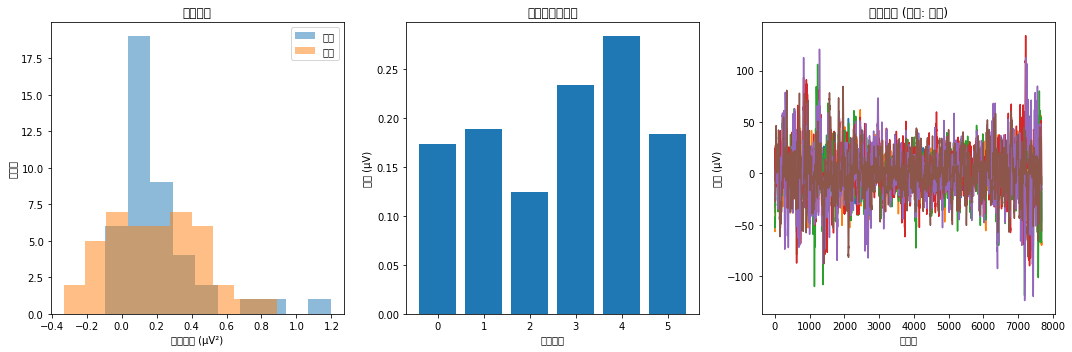

In [3]:
#可视化
#!/usr/bin/env python3
"""
平衡数据检查工具
功能：
1. 读取平衡后的NPZ文件
2. 解析数据结构
3. 可视化样本分布
"""

import numpy as np
import matplotlib.pyplot as plt
import os

def inspect_balanced_data(npz_path: str):
    """检查单个平衡文件"""
    print(f"\n正在检查文件: {npz_path}")
    
    try:
        with np.load(npz_path) as data:
            # 基础信息
            print("="*50)
            print(f"被试ID: {os.path.basename(npz_path).split('_')[1]}")
            print(f"随机种子: {data.get('random_seed_used', '未记录')}")
            
            # 数据结构
            print("\n[数据维度]")
            print(f"窗口数: {len(data['windows'])}")
            print(f"通道数: {data['windows'].shape[1]}")
            print(f"每窗口样本数: {data['windows'].shape[2]}")
            
            # 标签分布
            labels = data['labels']
            unique, counts = np.unique(labels, return_counts=True)
            print("\n[标签分布]")
            for u, c in zip(unique, counts):
                print(f"{'间期' if u == 0 else '前期'}: {c}个 ({c/len(labels):.1%})")
            
            # 数据来源
            print("\n[数据来源]")
            print("前期来源:", data['preictal_sources'])
            print("间期来源:", data['interictal_sources'])
            
            # 数据统计
            print("\n[统计特征]")
            mean_power = np.mean(data['windows'], axis=(1,2))
            print(f"平均功率范围: {np.min(mean_power):.2f} - {np.max(mean_power):.2f} μV²")
            print(f"通道均值: {np.mean(data['windows'], axis=(0,2))}")  # 各通道整体均值
            
            # 可视化
            plot_data_distribution(data)
            
    except Exception as e:
        print(f"文件读取失败: {str(e)}")

def plot_data_distribution(data: dict):
    """绘制数据分布图"""
    plt.figure(figsize=(15, 5))
    
    # 功率分布
    plt.subplot(131)
    plt.hist(np.mean(data['windows'][data['labels'] == 0], axis=(1,2)), 
             alpha=0.5, label='间期')
    plt.hist(np.mean(data['windows'][data['labels'] == 1], axis=(1,2)),
             alpha=0.5, label='前期')
    plt.xlabel('平均功率 (μV²)')
    plt.ylabel('窗口数')
    plt.legend()
    plt.title('能量分布')
    
    # 通道对比
    plt.subplot(132)
    channel_means = np.mean(data['windows'], axis=(0,2))
    plt.bar(range(len(channel_means)), channel_means)
    plt.xlabel('通道索引')
    plt.ylabel('均值 (μV)')
    plt.title('各通道信号均值')
    
    # 样本波形示例
    plt.subplot(133)
    sample_idx = np.random.randint(0, len(data['windows']))
    plt.plot(data['windows'][sample_idx].T)
    plt.xlabel('样本点')
    plt.ylabel('幅值 (μV)')
    plt.title(f'示例波形 (标签: {"前期" if data["labels"][sample_idx] else "间期"})')
    
    plt.tight_layout()
    plt.show()

def batch_inspect(data_dir: str):
    """批量检查所有平衡文件"""
    for npz_file in glob.glob(os.path.join(data_dir, "balanced_*.npz")):
        inspect_balanced_data(npz_file)

if __name__ == "__main__":
    # 配置路径（与平衡脚本的输出目录一致）
    BALANCED_DIR = "/root/balanced_data"
    
    # 检查单个文件或批量检查
    inspect_balanced_data(os.path.join(BALANCED_DIR, "balanced_chb01.npz"))  # 检查单个文件
    # batch_inspect(BALANCED_DIR)  # 批量检查所有文件
